# Signal check


> notebook to compare signal vs. non-signal based workflows for viral genome assembly

## Prepare the data

* download the complete ebola genomes from RefSeq

In [ ]:
!ncbi-genome-download --format fasta --assembly-level complete --fuzzy-genus --genus ebola viral -o tmp/

* download the Ebola (metagenome library prep) Nanopore data from the [artic data releases](http://artic.network/protocol_validation_2019.html)

In [ ]:
!mkdir tmp
!wget http://artic.s3.climb.ac.uk/run-folders/EBOV_Metagenomics.tar.gz --directory-prefix=tmp/
!tar -xvf tmp/EBOV_Metagenomics.tar.gz -C tmp/ --strip-components=1

* demux the reads with qcat:

In [ ]:
!cat tmp/fastq_pass/*.fastq | qcat -b tmp/demuxed_reads

> we want barcodes 9, 10 and 11 (9=Mayinga,10=Kikwit,11=Makona)

## Evaluating de-novo assembly with/without signal

### Mayinga

* run the assembly pipeline

In [ ]:
!nextflow run main.nf --reads $PWD/tmp/demuxed_reads/barcode09.fastq --fast5 $PWD/tmp/fast5_pass/ --output tmp/mayinga-assembly --assembler miniasm -profile conda --cpus 6 --mem 12GB

* compare the assemblies to the Ebola reference genomes

In [61]:
# get a file list of all the viral genomes we downloaded
!find $PWD/tmp/refseq/viral/GCF_00*/*.gz > tmp/ref-genome-list.txt

# get a file list of all the assemblies we just made
!find $PWD/tmp/mayinga-assembly/*.fasta > tmp/assembled-genome-list.txt

# run fastani to compute Average Nucleotide Identity
!fastani --ql tmp/assembled-genome-list.txt --rl tmp/ref-genome-list.txt -o tmp/fastani-out.tab --fragLen 100 --matrix

>>>>>>>>>>>>>>>>>>
Reference = [/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000848505.1/GCF_000848505.1_ViralProj14703_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000854085.1/GCF_000854085.1_ViralProj15006_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000855585.1/GCF_000855585.1_ViralProj15012_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000888475.1/GCF_000888475.1_ViralProj51257_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_000889155.1/GCF_000889155.1_ViralProj51245_genomic.fna.gz, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/refseq/viral/GCF_003505815.1/GCF_003505815.1_ASM350581v1_genomic.fna.gz]
Query = [/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/mayinga-assembly/assembly-polished-using-signal.fasta, /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/may

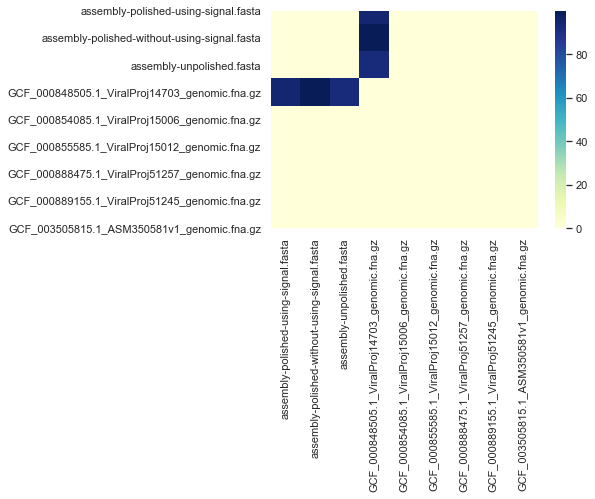

In [62]:
# plot the pairwise ANI scores as a heatmap
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)

# convert triangular matrix to a regular one (https://github.com/marbl/Mash/issues/9#issuecomment-509837201)
def lower_triangle_to_full_matrix(filename):
    num_lines_in_file = sum(1 for line in open(filename))
    distances = []
    sample_names = []

    with open(filename) as f:
        next(f) # skip sample count line
        for line in f:
            elements = line.strip().split('\t')
            for i, e in enumerate(elements):
                if e == 'NA':
                    elements[i] = 0.0
            elements[0] = os.path.basename(elements[0])
            sample_names.append(elements[0])
            row = [float(e) for e in elements[1:]]
            row.extend([0.0] * (num_lines_in_file-1-len(row)))
            distances.append(row)
        np_array = np.asarray(distances)
        index_upper = np.triu_indices(num_lines_in_file-1)
        np_array[index_upper] = np_array.T[index_upper]
        return pd.DataFrame(np_array, columns=sample_names, index=sample_names)

df = lower_triangle_to_full_matrix('tmp/fastani-out.tab.matrix')
sns.heatmap(df, cmap="YlGnBu")

> the closest reference genome is `GCF_000848505.1_ViralProj14703_genomic.fna.gz` (which is thankfully Mayinga)

* compare the each assembly to this reference genome

In [59]:
!find ./ -name GCF_000848505.1_ViralProj14703_genomic.fna.gz -exec gunzip -c {} + > tmp/ref-genome.fasta
!nucdiff tmp/ref-genome.fasta tmp/mayinga-assembly/assembly-unpolished.fasta tmp/nucdiff-out unpolished
!nucdiff tmp/ref-genome.fasta tmp/mayinga-assembly/assembly-polished-using-signal.fasta tmp/nucdiff-out polished-with-signal
!nucdiff tmp/ref-genome.fasta tmp/mayinga-assembly/assembly-polished-without-using-signal.fasta tmp/nucdiff-out polished-without-signal


Run NUCmer...

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/nucdiff-out/unpolished.ntref" of length 18960
# construct suffix tree for sequence of length 18960
# (maximum reference length is 536870908)
# (maximum query length is 4294967295)
# CONSTRUCTIONTIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/nucdiff-out/unpolished.ntref 0.00
# reading input file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/mayinga-assembly/assembly-unpolished.fasta" of length 18617
# matching query-file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/mayinga-assembly/assembly-unpolished.fasta"
# against subject-file "/Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp/nucdiff-out/unpolished.ntref"
# COMPLETETIME //anaconda3/envs/notebook-analysis/opt/mummer-3.23/mummer /Users/willrowe/Desktop/nanoporeSignal/signal-check/tmp

The difference detection inside fragments step is complete

The difference detection between fragments step is complete


In [63]:
# nucdiff will report SNPs, InDels and rearrangements, as well as the breadth of coverage, compared to the reference
import glob

nucdiffFiles = [i for i in glob.glob('tmp/nucdiff-out/results/*.out')]

dfs = []
for f in nucdiffFiles:
    fn = os.path.basename(f).replace('_stat.out', '')
    df = pd.read_csv(f, sep='\t', header=None, index_col=0)
    df.columns = [fn]
    dfs.append(df)
combined = pd.concat(dfs, axis=1, sort=False)

print(combined.loc[ ['Total number', 'Insertions', 'Deletions', 'Substitutions'] , : ])

print(combined.loc[ ['Uncovered ref regions num', 'Uncovered ref regions len'] , : ])

               polished-with-signal  polished-without-signal  unpolished
0                                                                       
Total number                 1094.0                      8.0      1466.0
Insertions                    305.0                      3.0       347.0
Deletions                     349.0                      3.0       499.0
Substitutions                 440.0                      2.0       620.0
                           polished-with-signal  polished-without-signal  \
0                                                                          
Uncovered ref regions num                   2.0                      2.0   
Uncovered ref regions len                  67.0                     65.0   

                           unpolished  
0                                      
Uncovered ref regions num         2.0  
Uncovered ref regions len        67.0  
